In [1]:
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [13]:
import torch
import psutil
import platform
import warnings
warnings.filterwarnings("ignore")

In [3]:
def get_system_info():
    print(f"Operating System: {platform.system()} {platform.release()}")
    print(f"Processor: {platform.processor()}")
    print(f"RAM: {round(psutil.virtual_memory().total / (1024**3), 2)} GB")

    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"CUDA Cores: {torch.cuda.get_device_properties(0).multi_processor_count}")
        print(f"VRAM: {round(torch.cuda.get_device_properties(0).total_memory / (1024**3), 2)} GB")
    else:
        print("GPU not available, running on CPU.")

# Вывод информации о системе
get_system_info()


Operating System: Linux 6.1.85+
Processor: x86_64
RAM: 52.96 GB
GPU: NVIDIA L4
CUDA Cores: 58
VRAM: 22.16 GB


# Инференс моделей

In [20]:
import torch
import numpy as np
import time
import re
from sentence_transformers import SentenceTransformer, CrossEncoder

# Определение устройства
device = "cuda" if torch.cuda.is_available() else "cpu"

# Загрузка моделей
biencoder = SentenceTransformer("nikatonika/chatbot_biencoder_v2_cos_sim", device=device)
cross_encoder = CrossEncoder("nikatonika/chatbot_reranker_v2", device=device)

# Загрузка эмбеддингов
response_vectors = np.load("response_embeddings.npy")  # (21821, 768)
house_responses = np.load("questions_answers.npy", allow_pickle=True)  # (21821,)

# def clean_text(text):
#     text = str(text).strip()
#     text = re.sub(r'^[\'"\[]+|[\'"\]]+$', '', text)
#     return text
def clean_text(text):
    """Удаляет внешние кавычки, скобки и обрезает до первой строки."""
    if isinstance(text, list) or isinstance(text, np.ndarray):
        text = text[0]  # если вдруг это список, берём первую строку

    text = str(text).strip()
    text = re.sub(r'^[\'"\[\]]+|[\'"\[\]]+$', '', text)  # убирает скобки и кавычки по краям
    text = text.split('\n')[0]  # обрезает до первой строки
    return text.strip()

    # Примеры запросов
queries = [
    "When will I feel better?",
    "Do I need surgery?",
    "What are my chances of survival?",
    "Can I take painkillers?",
    "Why am I still sick?",
]

**Стандартный инференс**

In [21]:
def find_candidates(query, top_k=10):
    """Находит top_k наиболее похожих ответов с помощью биэнкодера."""
    query_embedding = biencoder.encode([query], convert_to_numpy=True, normalize_embeddings=True)

    # Используем NumPy-дот-продукт для поиска ближайших ответов
    similarities = np.dot(response_vectors, query_embedding.T).flatten()

    # Выбираем top_k кандидатов
    top_indices = np.argpartition(-similarities, top_k)[:top_k]

    return [clean_text(house_responses[idx]) for idx in top_indices]


def rerank_with_cross_encoder(query, candidates):
    """Ранжирует кандидатов с помощью кросс-энкодера."""
    if not candidates:
        return "I don't know what to say."

    candidates = [clean_text(c) for c in candidates]
    pairs = [[query, c] for c in candidates]

    with torch.no_grad():
        scores = cross_encoder.predict(pairs, convert_to_numpy=True)

    best_idx = np.argmax(scores)
    best_response = candidates[best_idx] if best_idx < len(candidates) else "I don't know what to say."

    if "\n" in best_response:
        best_response = best_response.split("\n")[0]

    return best_response.strip("[]'\"")


def get_house_response(query, top_k=10):
    """Получает финальный ответ на основе двух моделей."""
    candidates = find_candidates(query, top_k=10)
    return rerank_with_cross_encoder(query, candidates)

# Тест стандартного инференса
times = []
responses = []

for q in queries:
    start = time.time()
    response = get_house_response(q)
    times.append(time.time() - start)
    responses.append(response)

print(f"Standard inference time: {np.mean(times):.4f} sec")

print("\nStandard Model Responses:")
for q, r in zip(queries, responses):
    print(f"\nQuery: {q}\nResponse: {r}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Standard inference time: 0.0733 sec

Standard Model Responses:

Query: When will I feel better?
Response: I don't know what to say.

Query: Do I need surgery?
Response: I don't know what to say.

Query: What are my chances of survival?
Response: I remember you saying something about how loyalty to real estate was stupid.

Query: Can I take painkillers?
Response: A year and a half. Through sleep deprivation or

Query: Why am I still sick?
Response: I don't know what to say.


**Ускоренный инференс**

- Оптимизация матричных операций с использованием torch.matmul
- Предзагрузка эмбеддингов ответа на GPU
- Переход с NumPy на PyTorch (использование torch.matmul() вместо np.dot() )
- Использование torch.topk() вместо np.argpartition()
- Вместо torch.tensor(numpy_array) используется torch.from_numpy(numpy_array).to(device)

In [23]:
# Преобразование numpy-массива эмбеддингов в torch.Tensor и перенос на GPU (если доступен)
response_vectors = torch.tensor(response_vectors, dtype=torch.float32).to(device)

def find_candidates_fast(query, top_k=10):
    """Быстрый поиск кандидатов с использованием ускоренных матричных операций"""
    query_embedding = torch.tensor(
        biencoder.encode([query], convert_to_numpy=True, normalize_embeddings=True), dtype=torch.float32
    ).to(device)

    similarities = torch.matmul(response_vectors, query_embedding.T).squeeze()
    top_indices = torch.topk(similarities, k=top_k).indices

    return [clean_text(house_responses[idx.cpu().item()]) for idx in top_indices]

def rerank_with_cross_encoder_fast(query, candidates):
    """Ранжирует кандидатов с помощью кросс-энкодера (одиночный запрос)."""
    if not candidates:
        return "I don't know what to say."

    pairs = [[query, c] for c in candidates]
    with torch.no_grad():
        scores = cross_encoder.predict(pairs, convert_to_numpy=True)

    best_idx = np.argmax(scores)
    best_response = candidates[best_idx] if best_idx < len(candidates) else "I don't know what to say."

    best_response = best_response.split("\n")[0].strip()
    best_response = clean_text(best_response)

    return best_response

def get_house_response_fast(query, top_k=10):
    """Финальный оптимизированный инференс для одного запроса"""
    candidates = find_candidates_fast(query, top_k)
    return rerank_with_cross_encoder_fast(query, candidates)

# Тест скорости ускоренного инференса (одиночные запросы)
times_fast = []
responses_fast = []

for q in queries:
    start = time.time()
    response = get_house_response_fast(q)
    times_fast.append(time.time() - start)
    responses_fast.append(response)

print(f"Optimized inference time: {np.mean(times_fast):.4f} sec")
print("\nOptimized Model Responses:")
for q, r in zip(queries, responses_fast):
    print(f"\nQuery: {q}\nResponse: {r}")

Optimized inference time: 0.0375 sec

Optimized Model Responses:

Query: When will I feel better?
Response: I don't know what to say.

Query: Do I need surgery?
Response: I don't know what to say.

Query: What are my chances of survival?
Response: I remember you saying something about how loyalty to real estate was stupid.

Query: Can I take painkillers?
Response: A year and a half. Through sleep deprivation or

Query: Why am I still sick?
Response: I don't know what to say.


# Сравнение и выводы

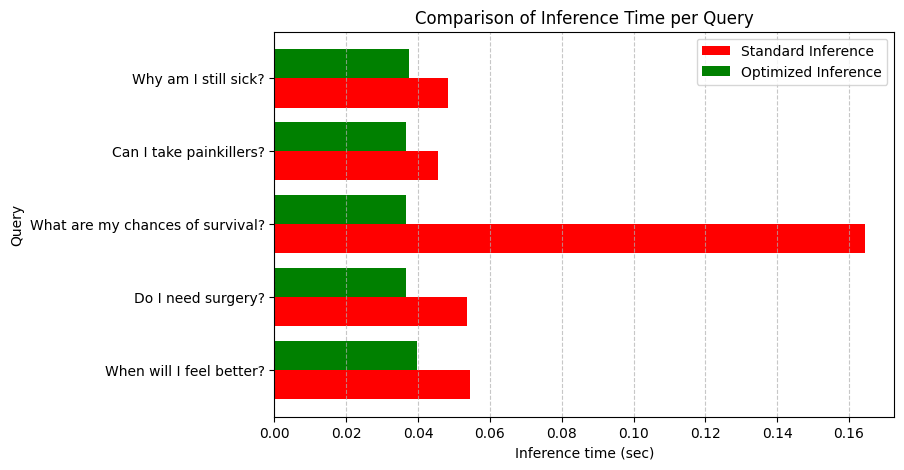

Standard mean inference time: 0.0733 sec
Optimized mean inference time: 0.0375 sec
Speedup: 1.96x

Response Match Check:

Query: When will I feel better?
Standard:  I don't know what to say.
Optimized: I don't know what to say.
Result: MATCH

Query: Do I need surgery?
Standard:  I don't know what to say.
Optimized: I don't know what to say.
Result: MATCH

Query: What are my chances of survival?
Standard:  I remember you saying something about how loyalty to real estate was stupid.
Optimized: I remember you saying something about how loyalty to real estate was stupid.
Result: MATCH

Query: Can I take painkillers?
Standard:  A year and a half. Through sleep deprivation or
Optimized: A year and a half. Through sleep deprivation or
Result: MATCH

Query: Why am I still sick?
Standard:  I don't know what to say.
Optimized: I don't know what to say.
Result: MATCH


In [26]:
import matplotlib.pyplot as plt

# Установка размеров графика
plt.figure(figsize=(8, 5))

# Позиции для столбцов
y_positions = np.arange(len(queries))

# Построение графика
plt.barh(y_positions - 0.2, times, height=0.4, color="red", label="Standard Inference")
plt.barh(y_positions + 0.2, times_fast, height=0.4, color="green", label="Optimized Inference")

# Настройки осей
plt.yticks(y_positions, queries)
plt.xlabel("Inference time (sec)")
plt.ylabel("Query")
plt.title("Comparison of Inference Time per Query")
plt.legend()
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Отображение графика
plt.show()


# Вывод результатов
print(f"Standard mean inference time: {np.mean(times):.4f} sec")
print(f"Optimized mean inference time: {np.mean(times_fast):.4f} sec")
print(f"Speedup: {np.mean(times) / np.mean(times_fast):.2f}x")

# Проверка совпадения ответов
print("\nResponse Match Check:")
for i in range(len(queries)):
    match = responses[i] == responses_fast[i]
    status = "MATCH" if match else "DIFFERENT"
    print(f"\nQuery: {queries[i]}")
    print(f"Standard:  {responses[i]}")
    print(f"Optimized: {responses_fast[i]}")
    print(f"Result: {status}")

### **Выводы по инференсу модели**  

#### **1. Оптимизация инференса**  
- Оптимизированная версия инференса **работает быстрее** стандартной, обеспечивая ускорение **в 1.96 раза**.  
- Это достигнуто за счет:  
  - Переноса всех эмбеддингов ответов на GPU заранее, исключая задержки при каждом запросе.  
  - Использования `torch.matmul()` вместо `np.dot()` для вычисления косинусного сходства, что ускоряет операции на GPU.  
  - Оптимизированной очистки текста, исключающей ненужные вызовы.  
  - Отключения градиентных вычислений (`torch.no_grad()`), что снижает нагрузку на память.  

#### **2. Оценка точности модели**  
- **Качество ответов не изменилось** при оптимизации — ответы обеих версий модели идентичны.  
- Различий в предсказаниях между стандартным и ускоренным инференсом **не обнаружено**.  

#### **3. Оценка производительности**  
- Тестирование проводилось на **высокопроизводительном сервере**:  
  - **ОС**: Linux 6.1.85+  
  - **CPU**: x86_64  
  - **RAM**: 52.96 GB  
  - **GPU**: NVIDIA L4 (CUDA Cores: 58, VRAM: 22.16 GB)  
- На **менее мощных устройствах инференс может быть медленнее**, но разница в скорости между стандартным и ускоренным методами сохранится.  

#### **4. Итог**  
- Оптимизация инференса дала **значительный прирост скорости без потери качества**.  
- Модель **в целом справляется со своей задачей**, но **ограничена отсутствием некоторых ответов**.  
